# Decision trees and random forests

In this Notebook, I'll use random forests algorithm to classify phones into 4 price categories.

I'm working with the data taken from [this](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?datasetId=11167&sortBy=voteCount) source. 

We have a dataset that consists of 2000 rows. 

I'll split it into a training and a testing dataset.

---

I learned a lot from [this](https://www.kaggle.com/code/archit9406/mobile-price-classification) notebook, [this](https://www.kaggle.com/learn/intro-to-machine-learning) Kaggle tutorial based my own code upon them.

---

Let's start by importing the libraries we'll need for an initial exploration of the training data.

Also, let's display the first five rows of the training data.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("/kaggle/input/mobile-price-classification/train.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


We see that this dataset consists of numerous columns storing data on the features of different mobile phones.

We, for example, have info on each phone's pattery power, height and width in pixels, ram, etc.

Our challenge is to use this data to predict a phone's price range.

Let's see how the NAs are distributed across the dataset:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Nice! There are no NAs here :) 

From the above output we also see that all of our columns are numeric.

Let's finally check whether we have duplicates in our data:

In [4]:
print(sum(df.duplicated()))

0


No duplicates :)

Now, let's see how many values there are per each category of the `df['price_range']` column.

In [5]:
df['price_range'].value_counts().sort_index()

0    500
1    500
2    500
3    500
Name: price_range, dtype: int64

Perfect. All the values are distributed equally.

Let's end our exploration by visualizing the correlation matrix of the `train` dataset. 

This can be done pretty easily with **seaborn**, but I'll rather use **plotly**, 
since it provides us a few additional functionalities.

I heavily borrowed from [this](https://stackoverflow.com/a/67794682) super helpful StackOverflow answer :)

In [6]:
import plotly.figure_factory as ff
import plotly.express as px

corr = pd.DataFrame(df.corr())
mask = np.triu(np.ones_like(corr, dtype=bool))
df_mask = corr.mask(mask)

fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(), 
                                  x=df_mask.columns.tolist(),
                                  y=df_mask.columns.tolist(),
                                  colorscale=px.colors.diverging.RdBu,
                                  showscale=True, ygap=1, xgap=1)

fig.update_xaxes(side="bottom")

fig.update_layout(
    title_text='Heatmap', 
    title_x=0.5, 
    height=600,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange='reversed',
    template='simple_white')

## Let's get rid of the text manually
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].text = ""

fig.show()

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


We see that RAM has the highest correlation with price range. 

Battery power, and width and height in pixels are moderately correlated with price range.

Other variables are very weakly correlated with price range.

## Decision Tree Classifier

Now, let's prepare our data for the Decision Tree model.

First, we'll separate the features (independent variables) from the label (dependent variable) 
in the `df` dataset. 

In [7]:
X = df.drop(["price_range"], axis = 1) 
y = df["price_range"]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [9]:
from sklearn.tree import DecisionTreeClassifier 

## Fit the Decision Tree classifier with default hyper-parameters
classifier = DecisionTreeClassifier(random_state = 0)
model = classifier.fit(X_train, y_train)
print(model)

DecisionTreeClassifier(random_state=0)


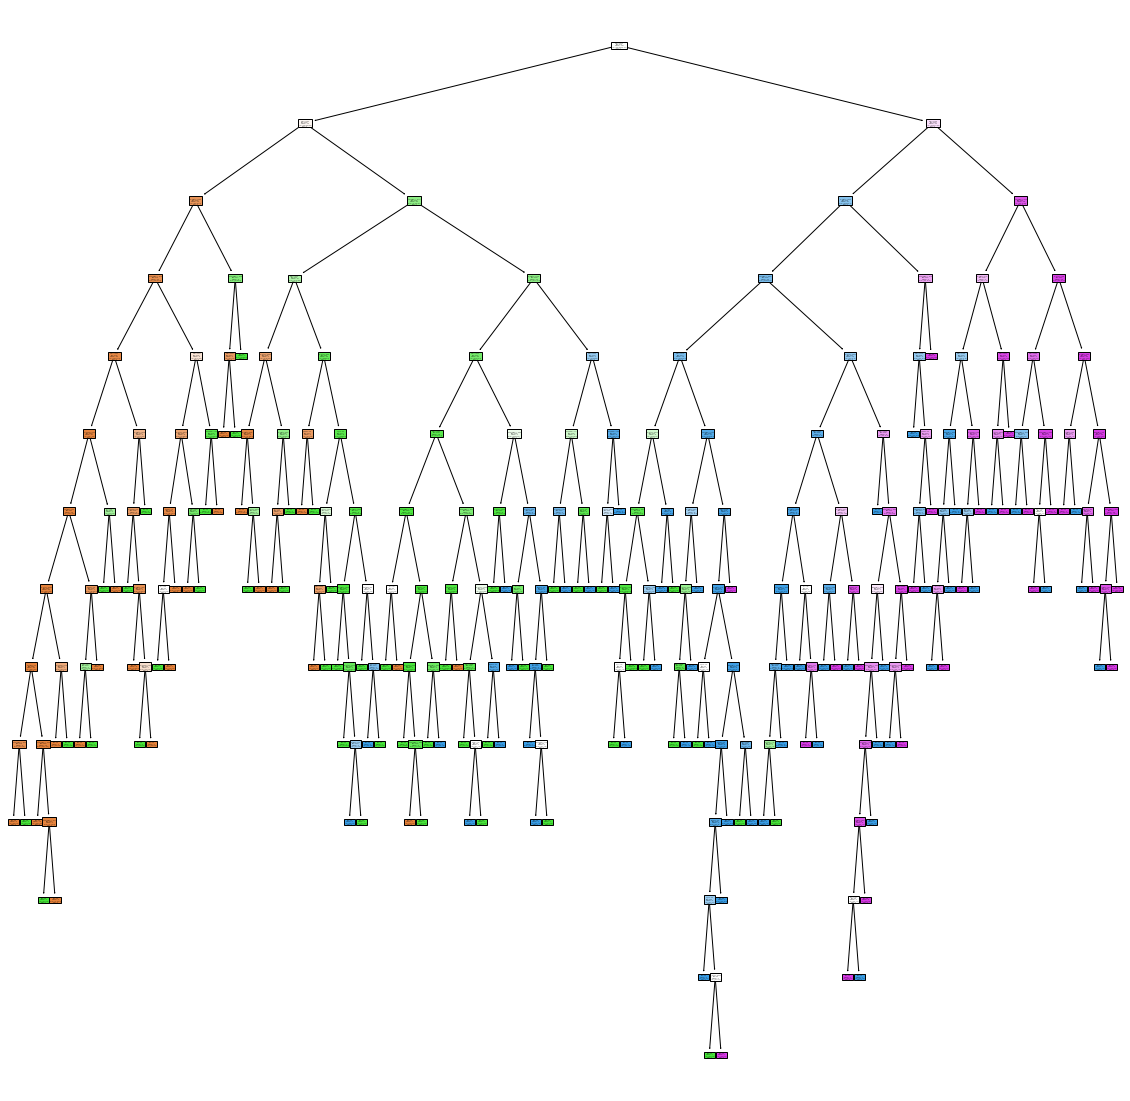

In [10]:
from sklearn import tree
import matplotlib.pyplot as plt

## Visualizing the classifier
fig = plt.figure(figsize = (20, 20))
_ = tree.plot_tree(classifier, 
                   feature_names = X_train.columns,  
                   class_names = ["0", "1", "2", "3"],
                   filled = True)

In [11]:
from sklearn.metrics import mean_absolute_error

## Train data
predicted_phone_prices = classifier.predict(X_train)
print(mean_absolute_error(y_train, predicted_phone_prices))

## Test data
predicted_phone_prices = classifier.predict(X_test)
print(round(mean_absolute_error(y_test, predicted_phone_prices), 2))

0.0
0.17


In [12]:
def get_mae(max_leaf_nodes, X_train, X_test, y_train, y_test):
    model = DecisionTreeClassifier(max_leaf_nodes = max_leaf_nodes, random_state = 0)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds_val)
    return(mae)

## compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [5, 50, 500, 5000, 50000]:
    my_mae = get_mae(max_leaf_nodes, X_train, X_test, y_train, y_test)
    print(f"Max leaf nodes: {max_leaf_nodes}  \t\t Mean Absolute Error:  {my_mae}")

Max leaf nodes: 5  		 Mean Absolute Error:  0.265
Max leaf nodes: 50  		 Mean Absolute Error:  0.15833333333333333
Max leaf nodes: 500  		 Mean Absolute Error:  0.16333333333333333
Max leaf nodes: 5000  		 Mean Absolute Error:  0.16333333333333333
Max leaf nodes: 50000  		 Mean Absolute Error:  0.16333333333333333


So, we'd get the best results with max leaf nodes equal to 50 :)

Now, let's try to improve our data a bit, to try and get the best possible results out of our random forest classification models. Let's see how much they will improve on the decision tree classifier.

In [13]:
from sklearn.metrics import classification_report

tree_model = DecisionTreeClassifier(max_leaf_nodes = 50, random_state = 0)
tree_model.fit(X_train, y_train)

print(classification_report(y_test, tree_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       151
           1       0.80      0.78      0.79       135
           2       0.78      0.76      0.77       151
           3       0.87      0.90      0.88       163

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



## Backward elimination

We can use a linear regression model to see which variables are the least likely to be related with price categories, and drop them out of our the set of features we'll feed into the classification algorithm. 

In [14]:
import statsmodels.api as sm

regressor_ols = sm.OLS(endog = y_train, exog = X_train.values).fit()
print(regressor_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:            price_range   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                              1660.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):                        0.00
Time:                        11:31:30   Log-Likelihood:                         -593.23
No. Observations:                1400   AIC:                                      1226.
Df Residuals:                    1380   BIC:                                      1331.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [15]:
## Buliding the optimal data using automatic backward elimnation

def backward_elimination(train_x_data, test_x_data, significance_level):
    
    train_x_data = train_x_data.values ## -> array
    test_x_data = test_x_data.values ## -> array
    
    num_variables = train_x_data.shape[1]

    ## Here's what we'll repeat for as many times as there are variables in our training dataset:
    for i in range(0, num_variables): 
        ## We fit the model to the data
        regressor_OLS = sm.OLS(y_train, train_x_data).fit()
        ## We identify the highest p-value (corresponding to the variable that's the least likely to ... 
        ## ... have a systematic impact on the dependent variable)
        max_p_value = max(regressor_OLS.pvalues)
        ## If this highest p-value is greater than the significance level we've chosen to compare against
        if max_p_value > significance_level:
            ## We look for the variable it corresponds to, by searching through variables at all ...
            ## ... available indexes
            for j in range(0, num_variables):
                ## If we find such a variable:
                if (regressor_OLS.pvalues[j] == max_p_value):
                    
                    ## We remove it from the train and test datasets
                    train_x_data = np.delete(train_x_data, j, 1)
                    test_x_data = np.delete(test_x_data, j, 1)
                    
                    num_variables -= 1
                    
    print(regressor_OLS.summary())
    return train_x_data, test_x_data
    
X_train, X_test = backward_elimination(X_train, X_test, 0.05)

                                 OLS Regression Results                                
Dep. Variable:            price_range   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              2070.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):                        0.00
Time:                        11:31:30   Log-Likelihood:                         -596.74
No. Observations:                1400   AIC:                                      1225.
Df Residuals:                    1384   BIC:                                      1309.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [16]:
## Applying feature scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators = 100, 
                                      criterion="entropy",
                                      random_state = 0)

forest_model.fit(X_train, y_train)

phone_preds = forest_model.predict(X_test)
print(mean_absolute_error(y_test, phone_preds))

0.11666666666666667


In [18]:
print(classification_report(y_test, forest_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       151
           1       0.81      0.87      0.84       135
           2       0.82      0.80      0.81       151
           3       0.97      0.87      0.92       163

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.89      0.88      0.88       600

